In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# from moseq2_nlp.data import get_embedding_representation, get_transition_representation, get_usage_representation, load_groups
import moseq2_nlp.train as trainer
from typing import Literal

from moseq2_viz.util import parse_index, read_yaml
from moseq2_viz.model.util import (get_transition_matrix, parse_model_results)
from moseq2_nlp.data import get_embedding_representation, load_groups, get_raw_data
from moseq2_nlp.utils import ensure_dir, write_yaml
from moseq2_nlp.train import train_regressor
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
# !pip install lime

In [2]:
custom_groupings = ['MIA bsl + gaba', 'MIA 3d', 'MIA 10d + gaba', 'MIA bsl + saline', 'MIA bsl', 'MIA 10d + saline'] #put MIA over here

# model_path = '/Users/aishwaryaharpale/Downloads/Abraira-Lab/2021-02-19_Meloxicam/rOT_model_1000.p'
# index_path = '/Users/aishwaryaharpale/Downloads/Abraira-Lab/2021-02-19_Meloxicam/moseq2-index.role.yaml'
# train_config = '/Users/aishwaryaharpale/tischfield-lab/moseq2-nlp/train-config.yaml'

model_path = '/Users/aishwaryaharpale/Downloads/2022-09-02_Meloxicam/models-mean-target/rOT_model_1000-5.fixed.p'
index_path = '/Users/aishwaryaharpale/Downloads/2022-09-02_Meloxicam/moseq2-index.role.yaml'
train_config = '/Users/aishwaryaharpale/tischfield-lab/moseq2-nlp/train-config-manon.yaml'

config_data = read_yaml(train_config)
group_map = load_groups(index_path, custom_groupings)

In [13]:
# for i in class_names:
#     if "MIA" in i:
#         custom_groupings.append(i)
# print(custom_groupings)

['MIA bsl + gaba', 'MIA 3d', 'MIA 10d + gaba', 'MIA bsl + saline', 'MIA bsl', 'MIA 10d + saline']


In [22]:
# for key, val in config_data.items():
#     print(key, " : ", val, " \n")

exp_dir = ensure_dir(os.path.join(config_data['save_dir'], config_data['name']))
group_map

{'MIA bsl + gaba': 'MIA bsl + gaba',
 'MIA 3d': 'MIA 3d',
 'MIA 10d + gaba': 'MIA 10d + gaba',
 'MIA bsl + saline': 'MIA bsl + saline',
 'MIA bsl': 'MIA bsl',
 'MIA 10d + saline': 'MIA 10d + saline'}

In [23]:
# ALL CLASSES :
# ['14d carrageenan 2022 exclude' '24hrs carrageenan + meloxicam'
#  '24hrs carrageenan + saline' '24hrs carrageenan June exclude'
#  '4h carrageenan 2022 exclude' '4hrs carrageenan'
#  '6d carrageenan 2022 exclude' 'CAR 14d' 'CAR 24h + mel'
#  'CAR 24h + saline' 'CAR 4h' 'CAR 6d' 'CAR bsl' 'CAR bsl + mel'
#  'CAR bsl + saline' 'CAR ctrl 14d' 'CAR ctrl 24h' 'CAR ctrl 4h'
#  'CAR ctrl 6d' 'CAR ctrl bsl' 'MIA 10d + gaba' 'MIA 10d + saline' 'MIA 3d'
#  'MIA bsl' 'MIA bsl + gaba' 'MIA bsl + saline' 'None' 'baseline'
#  'baseline + meloxicam' 'baseline exclude']

100%|██████████| 388/388 [00:19<00:00, 20.30it/s]


['14d carrageenan 2022 exclude' '24hrs carrageenan + meloxicam'
 '24hrs carrageenan + saline' '24hrs carrageenan June exclude'
 '4h carrageenan 2022 exclude' '4hrs carrageenan'
 '6d carrageenan 2022 exclude' 'CAR 14d' 'CAR 24h + mel'
 'CAR 24h + saline' 'CAR 4h' 'CAR 6d' 'CAR bsl' 'CAR bsl + mel'
 'CAR bsl + saline' 'CAR ctrl 14d' 'CAR ctrl 24h' 'CAR ctrl 4h'
 'CAR ctrl 6d' 'CAR ctrl bsl' 'MIA 10d + gaba' 'MIA 10d + saline' 'MIA 3d'
 'MIA bsl' 'MIA bsl + gaba' 'MIA bsl + saline' 'None' 'baseline'
 'baseline + meloxicam' 'baseline exclude']


In [5]:
labels, features = get_embedding_representation(config_data['model_path'], config_data['index_path'], group_map, emissions=True, bad_syllables=config_data['bad_syllables'],
                            dm=config_data['dm'], embedding_dim=config_data['embedding_dim'], embedding_window=config_data['embedding_window'], embedding_epochs=config_data['embedding_epochs'], 
                            min_count=config_data['min_count'],
                            model_dest=os.path.join(exp_dir, 'doc2vec'),negative=0, ablation='none', phrase_path=None, seed=config_data['seed'])

100%|██████████| 388/388 [00:19<00:00, 20.33it/s]


In [6]:
from moseq2_nlp.data import get_usage_representation


labels2, usages = get_usage_representation(model_file=config_data['model_path'], index_file=config_data['index_path'],group_map=group_map)


100%|██████████| 388/388 [00:00<00:00, 708.44it/s] 


In [7]:
inds = [ind for ind in range(len(labels2)) if 'MIA' in labels2[ind]]
labels2 = [labels2[ind] for ind in inds]
usages = usages[inds]

In [8]:
# This is a DBOW based model only (Does not used DM-Distributed Memory)
model = Doc2Vec.load("/Users/aishwaryaharpale/tischfield-lab/Reverse-Mapping/Manon's-data/rOT/doc2vec.model")

In [9]:
inds = [ind for ind in range(len(labels)) if 'MIA' in labels[ind]]
labels = [labels[ind] for ind in inds]
features = features[inds]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=config_data['test_size'], random_state=config_data['split_seed'], stratify=labels)
clf = train_regressor(X_train, y_train, config_data['k'], config_data['penalty'], config_data['num_c'], config_data['seed'], config_data['multi_class'])
class_names = list(set(labels))

In [11]:
from sklearn.metrics import classification_report

y_pred_train = clf.predict(X_train)
report_train = classification_report(y_train, y_pred_train, output_dict=True)

# print("Report train: ", report_train)
for key in report_train:
    print(key, " : ", report_train[key])

MIA 10d + gaba  :  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 6}
MIA 10d + saline  :  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7}
MIA 3d  :  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}
MIA bsl  :  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13}
MIA bsl + gaba  :  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7}
MIA bsl + saline  :  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 7}
accuracy  :  1.0
macro avg  :  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52}
weighted avg  :  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 52}


In [12]:


y_pred_test = clf.predict(X_test)
report_test = classification_report(y_test, y_pred_test, output_dict=True)
for key in report_test:
    print(key, " : ", report_test[key])

MIA 10d + gaba  :  {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}
MIA 10d + saline  :  {'precision': 0.14285714285714285, 'recall': 0.3333333333333333, 'f1-score': 0.2, 'support': 3}
MIA 3d  :  {'precision': 0.5555555555555556, 'recall': 0.7142857142857143, 'f1-score': 0.6250000000000001, 'support': 7}
MIA bsl  :  {'precision': 1.0, 'recall': 0.2857142857142857, 'f1-score': 0.4444444444444445, 'support': 7}
MIA bsl + gaba  :  {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 3}
MIA bsl + saline  :  {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 3}
accuracy  :  0.46153846153846156
macro avg  :  {'precision': 0.6164021164021164, 'recall': 0.4444444444444445, 'f1-score': 0.46157407407407414, 'support': 26}
weighted avg  :  {'precision': 0.666056166056166, 'recall': 0.46153846153846156, 'f1-score': 0.48408119658119664, 'support': 26}


In [14]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names, bow=True)

In [15]:
sentences, out_groups = get_raw_data(config_data['model_path'], config_data['index_path'], max_syllable=100, \
                            emissions=config_data['emissions'], bad_syllables=config_data['bad_syllables'], ablation='none', phrase_path=None)

100%|██████████| 388/388 [00:19<00:00, 20.02it/s]


In [16]:
inds = [ind for ind in range(len(out_groups)) if 'MIA' in out_groups[ind]]
out_groups = [out_groups[ind] for ind in inds]
sentences = [sentences[ind] for ind in inds]

In [17]:
def new_predict(sentences):
    embeddings = []
    for sent in sentences:
        embeddings.append(model.infer_vector(sent.split(' ')))
    embeddings = np.array(embeddings)
    return clf.predict_proba(embeddings.reshape(-1, 70))

In [18]:
embedding = model.infer_vector(sentences[0])
# embedding_string = []
# for emb in embedding:
#     embedding_string.append(str(emb))
print(clf.predict_proba(embedding.reshape(-1,70)))
#     embedding_string.append(str(emb))
print(embedding.reshape(-1,70).shape)
print(embedding.shape)

[[0.15057791 0.09755563 0.08983892 0.52264949 0.0088192  0.13055885]]
(1, 70)
(70,)


In [19]:
top10freq = {}
for item in set(out_groups):
    top10freq[item] = {}

print(top10freq)

{'MIA 10d + gaba': {}, 'MIA 3d': {}, 'MIA bsl + saline': {}, 'MIA bsl + gaba': {}, 'MIA bsl': {}, 'MIA 10d + saline': {}}


In [20]:
from collections import Counter

Counter(out_groups)

Counter({'MIA bsl': 20,
         'MIA bsl + saline': 10,
         'MIA 10d + gaba': 9,
         'MIA 10d + saline': 10,
         'MIA 3d': 19,
         'MIA bsl + gaba': 10})

In [21]:
for sentence, actual_class in zip(sentences, out_groups):
    sent = ' '.join(item for item in sentence)
    exp = explainer.explain_instance(sent,new_predict, num_samples=1000)
    for feature_imp in exp.as_list():
        feat, wt = feature_imp
        if feat in top10freq[actual_class]:
            top10freq[actual_class][feat] += 1
        else:
            top10freq[actual_class][feat] = 1

for item in top10freq.keys():
    print(item," : ", len(top10freq[item]))

KeyboardInterrupt: 

In [ ]:
dist.keys()

dict_keys(['scalar[velocity_2d_mm]', 'scalar[velocity_3d_mm]', 'scalar[width_mm]', 'scalar[length_mm]', 'scalar[height_ave_mm]', 'scalar[angle]'])

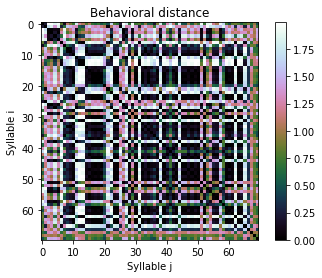

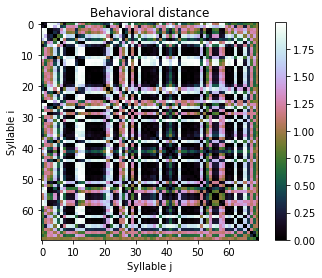

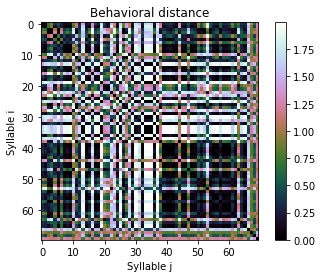

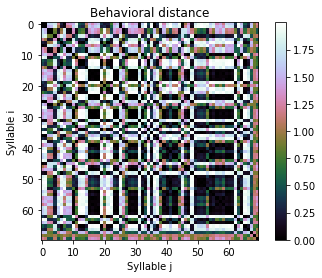

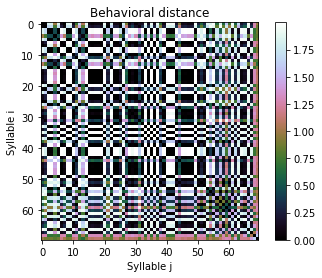

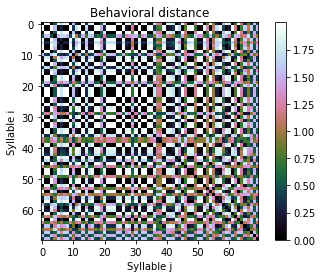

In [74]:
from moseq2_viz.model.dist import get_behavioral_distance
from moseq2_viz.util import parse_index

index, sorted_index = parse_index(index_path)
dist = get_behavioral_distance(sorted_index, 
                               model_path, 
                               distances=['scalars'], 
                               max_syllable=None)

for key in dist.keys():
    fig, ax = plt.subplots(1)
    h =ax.imshow(dist[key], aspect='equal', cmap='cubehelix')
    ax.set_title('Behavioral distance')
    ax.set_xlabel('Syllable j')
    ax.set_ylabel('Syllable i')
    plt.colorbar(h, ax=ax)
    plt.show()

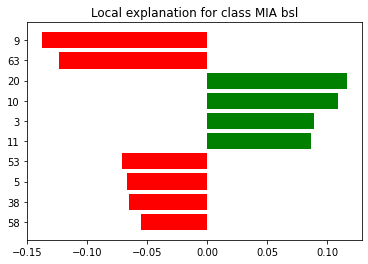

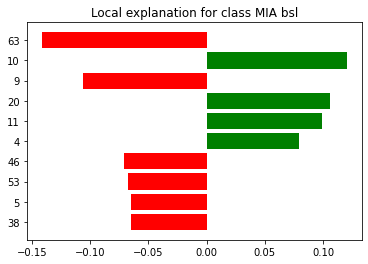

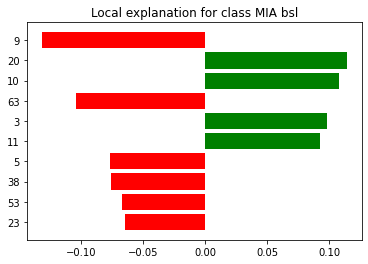

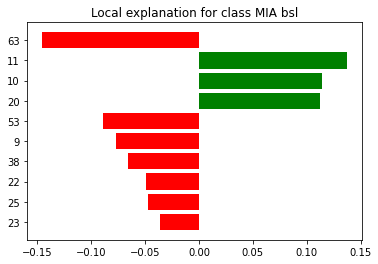

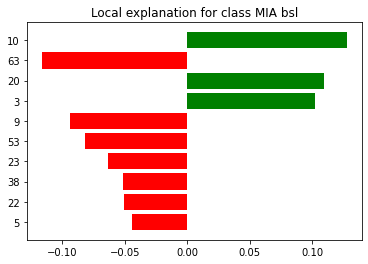

In [75]:
# (fig, subplots) = plt.subplots(1,5, figsize = (15,8))
# fig.tight_layout(h_pad=2)
# num_samples = [50,100,250,500,800,1000,2000,3000,4000,5000]
num_samples = [1000 for _ in range(5)]
len(num_samples)
sent1 = ' '.join(item for item in sentences[0])

for num in num_samples:
    exp1 = explainer.explain_instance(sent1,new_predict, num_samples=num)
    ax = exp1.as_pyplot_figure()

# title = fig.suptitle('model0 TSNE rOT 2D', size='16')
# fig.subplots_adjust(top=0.88)
# legend = fig.legend(handles=[meloxicam24h,saline24h,carrageenan,baseline,baselineMeloxicam],bbox_to_anchor=(1.04,0.5), loc="center left")

In [20]:
sent1 = ' '.join(item for item in sentences[0])
print("Actual label : ",out_groups[0])
exp1 = explainer.explain_instance(sent1,new_predict, num_samples=50)
exp1.as_list()

Actual label :  CAR 4h


[('37', 0.008553917259428332),
 ('15', 0.005582562242555695),
 ('0', 0.005124921698582118),
 ('28', 0.0034349529996925295),
 ('21', 0.0028688337160825464),
 ('2', -0.002294522441824893),
 ('4', 0.0020325222522906417),
 ('47', -0.0018521888964554425),
 ('45', 0.0006087968266065185),
 ('17', 0.000213598569859109)]

In [43]:

from moseq2_viz.model.util import parse_model_results, get_syllable_statistics
model_results = parse_model_results(model_path)
usages, durations = get_syllable_statistics(model_results['labels'])
print("Usages: ")
for feature_imp in exp1.as_list():
    feat, wt = feature_imp
    print(int(feat), " : ", usages[int(feat)])

Usages: 
10  :  3721
53  :  12206
63  :  12037
9  :  12076
22  :  6581
23  :  14768
5  :  0
37  :  0
46  :  1
34  :  0


Actual label :  MIA bsl + saline
{34: 0, 53: 12206, 7: 6578, 20: 2667, 41: 9045, 14: 0, 23: 14768, 33: 0, 11: 7891, 17: 1267}


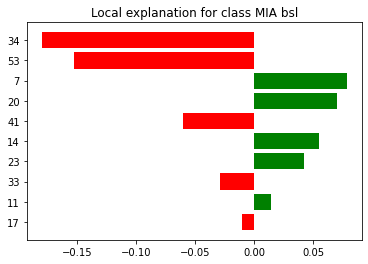

In [76]:
sent2 = ' '.join(item for item in sentences[1])
print("Actual label : ",out_groups[1])
exp2 = explainer.explain_instance(sent2,new_predict, num_samples=80)
uses={}
for feature_imp in exp2.as_list():
    feat, wt = feature_imp
    # print(int(feat), " : ", usages[int(feat)])
    uses[int(feat)] = usages[int(feat)]
fig = exp2.as_pyplot_figure()
print(uses)